# Employee Sentiment Analysis

This project involves analyzing an unlabeled dataset of employee messages to assess sentiment and engagement. The task is to work from raw data and derive insights using natural language processing (NLP) and statistical analysis techniques. The project is divided into several distinct tasks, each focusing on a different aspect of data analysis and
model development.

## Setup and Data Collection

In [1]:
import pandas as pd

You need to download the dataset file and put it in the same folder as this file. I will try and automate the downloading process in the future.

In [4]:
!ls

actual_vs_predicted_monthly_sentiment.png  sentiment_over_time.png
actual_vs_predicted_sentiment_scores.png   test.xlsx
distribution_of_monthly_residuals.png	   top_negative_employees_2010.png
distribution_of_residuals.png		   top_negative_employees_2011.png
model_comparison.png			   top_positive_employees_2010.png
residual_plot_monthly_sentiment.png	   top_positive_employees_2011.png
residual_plot.png			   top_senders.png
sample_data				   top_subjects_Negative.png
sentiment_distribution.png		   top_subjects_Neutral.png
sentiment_labeled_data.csv		   top_subjects_Positive.png


Some basic functions to view and understand the dataset

In [5]:
df = pd.read_excel('test.xlsx')
df.head(10)

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com
5,RE: Favor,"sure, just call me the bank that delivers.\n \...",2011-10-23,eric.bass@enron.com
6,MG Inventory Summaries,Inventory summaries for both MGL and MGMCC as ...,2010-04-05,kayne.coulter@enron.com
7,Forgot the Attachment,Please print attachment and make sure that e:m...,2010-04-21,patti.thompson@enron.com
8,Garvin Brown - AXIA Sr. Power Scheduler,Please advise me of your interest in Garvin's ...,2010-02-07,sally.beck@enron.com
9,More Dallas ASE Information,The start time for Tuesday morning has been ch...,2010-02-06,kayne.coulter@enron.com


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Subject  2191 non-null   object        
 1   body     2191 non-null   object        
 2   date     2191 non-null   datetime64[ns]
 3   from     2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 68.6+ KB


## Detailed Tasks

### **Sentiment Labeling**

Use an LLM to label the 'body' column of the DataFrame as Positive, Negative, or Neutral, and add the labels as a new column to the DataFrame.

First I will try labeling using built-in LLM from transformers.

#### Sentiment analysis with transformers pipeline

Configure the environment to use a suitable LLM for sentiment analysis.


In [7]:
%pip install transformers


Import the pipeline function from the transformers library and create a sentiment analysis pipeline using a pre-trained model suitable for this task.



In [8]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


#### Define sentiment function
Create a function that takes an email body as input and uses the LLM to return a sentiment label (Positive, Negative, or Neutral).


In [9]:
def get_sentiment(text):
    """
    Analyzes the sentiment of the input text using a pre-trained sentiment analysis pipeline.

    Args:
        text: The input string (email body) to analyze.

    Returns:
        A string representing the sentiment label ('Positive', 'Negative', or 'Neutral').
    """
    result = sentiment_pipeline(text)
    label = result[0]['label']

    if label == 'POSITIVE':
        return 'Positive'
    elif label == 'NEGATIVE':
        return 'Negative'
    else:
        return 'Neutral'

#### Apply sentiment analysis

Apply the sentiment function to the 'body' column of the DataFrame to generate sentiment labels for each email.


In [10]:
sentiment_labels = df['body'].apply(get_sentiment)

In [11]:
sentiment_labels.value_counts()

,count
body,
Negative,1191
Positive,1000


The dataset after being labeled is imbalance, while the number of Negative and Positive seems balanced, there aren't any samples with the Neutral label. This could either because of the characteristics of the dataset itself or because of the label model. To get a better understanding, here I will also implement another labeling method using TextBlob.

#### Sentiment analysis with textblob model

Use TextBlob's built-in sentiment analysis to generate sentiment labels and compare TextBlob's sentiment labels with the LLM-based labels.


Import the TextBlob class and define the function to get sentiment labels from TextBlob based on polarity. Then apply the function to the 'body' column of the DataFrame and calculate the value counts of the TextBlob sentiment labels. Finally, calculate and print the cross-tabulation of the LLM-based and TextBlob-based sentiment labels to compare them.



In [12]:
%pip install textblob

In [13]:
from textblob import TextBlob

def get_textblob_sentiment(text):
    """
    Analyzes the sentiment of the input text using TextBlob's polarity.

    Args:
        text: The input string (email body) to analyze.

    Returns:
        A string representing the sentiment label ('Positive', 'Negative', or 'Neutral').
    """
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'body' column
df['textblob_sentiment'] = df['body'].apply(get_textblob_sentiment)

# Calculate and print the value counts for the 'textblob_sentiment' column
print("TextBlob Sentiment Distribution:")
print(df['textblob_sentiment'].value_counts())

# Calculate and print a confusion matrix or cross-tabulation
print("\nComparison of LLM Sentiment vs. TextBlob Sentiment:")
comparison_matrix = pd.crosstab(df['textblob_sentiment'], sentiment_labels)
print(comparison_matrix)

TextBlob Sentiment Distribution:
textblob_sentiment
Positive    1218
Neutral      703
Negative     270
Name: count, dtype: int64

Comparison of LLM Sentiment vs. TextBlob Sentiment:
body                Negative  Positive
textblob_sentiment                    
Negative                 197        73
Neutral                  442       261
Positive                 552       666


In this case, TextBlob labeling still shows an imbalanced dataset. On the upside, the records now have records being labeled "Neutral". Therefore, I choose this method for better representation.

In [14]:
df.head()

,Subject,body,date,from,textblob_sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative


Save the new dataframe to a file for backup.

In [15]:
df.rename(columns={"textblob_sentiment":"sentiment"}, inplace=True)
df.to_csv('sentiment_labeled_data.csv', index=False)


Review the generated sentiment labels for accuracy and refine the sentiment function or LLM parameters if necessary.


In [16]:
sample_size = 5
sampled_df = df.sample(n=sample_size, random_state=42)

for index, row in sampled_df.iterrows():
    print(f"--- Row Index: {index} ---")
    print(f"Email Body:\n{row['body'][:500]}...") # Print first 500 characters
    print(f"LLM Sentiment: {row['sentiment']}")
    print("-" * 20)

--- Row Index: 382 ---
Email Body:
Yes'em, I is here.  Bout to go to lunch!  Friday may work for me I'll drop you a line in a little while!

DB

 ...
LLM Sentiment: Negative
--------------------
--- Row Index: 632 ---
Email Body:
I'm in for Wed. night Kick Off Dance, tell me when & where to meet you!

DB

 ...
LLM Sentiment: Neutral
--------------------
--- Row Index: 1670 ---
Email Body:
http://atlas.spaceports.com/~cfarley/tbs.htm...
LLM Sentiment: Neutral
--------------------
--- Row Index: 211 ---
Email Body:
We're trying to get a demo setup - probably for lunch time one day this week. 

 In the meantime, you can view the homepage at 
http://test.entelligence.enron.com  

Security will prevent you from going any further until you have been setup.  
If you wish to gain access, please submit a request through erequest at 
http://itc.corp.enron.com.  Currently, you can only request test access.  
Production access should be added later this week.
...
LLM Sentiment: Neutral
-----------

#### Summary

**Data Analysis Key Findings**

*   The `transformers` library was successfully installed, and a sentiment analysis pipeline using the `distilbert-base-uncased-finetuned-sst-2-english` model was set up.
*   A Python function `get_sentiment` was created to utilize the sentiment analysis pipeline and return sentiment labels ('Positive', 'Negative', or 'Neutral') for input text.
*   The `get_sentiment` function was applied to the 'body' column of the DataFrame, generating a series of sentiment labels.
*   The `get_textblob_sentiment` function was used to label the dataset using TextBlob built-in.
*   Using the transformer pipeline, the dataset appears to be imbalance with no Neutral label.
*   Using TextBlob, the labels are more evenly distributed, though the dataset is still imbalance.
*   A manual review of a random sample of 20 rows indicated that the LLM's sentiment labels generally aligned with the content, and the accuracy was deemed acceptable for this general sentiment analysis task.


###**Exploratory Data Analysis (EDA)**

Perform exploratory data analysis (EDA) on the provided DataFrame, focusing on data structure, sentiment distribution, and trends over time. Include visualizations to effectively communicate findings.

#### Examine data structure

Check the number of records, data types, and identify missing values in the DataFrame.


In [17]:
df.shape

(2191, 5)

In [18]:
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Subject    2191 non-null   object        
 1   body       2191 non-null   object        
 2   date       2191 non-null   datetime64[ns]
 3   from       2191 non-null   object        
 4   sentiment  2191 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 85.7+ KB

Missing values per column:
Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


There are 2191 records and 5 columns. There aren't any missing values detected in the dataframe.

#### Analyze sentiment distribution

Calculate and visualize the distribution of the sentiment labels (Positive, Negative, Neutral) to see the overall sentiment in the emails.


In [19]:
sentiment_counts = df['sentiment'].value_counts()

print(sentiment_counts)

sentiment
Positive    1218
Neutral      703
Negative     270
Name: count, dtype: int64


The dataset is imbalanced, there are 270 records being labeled 'Negative', 1218 being labeled 'Positive' and 703 labeled 'Neutral'. Next we will plot the bar graph for better visualization.

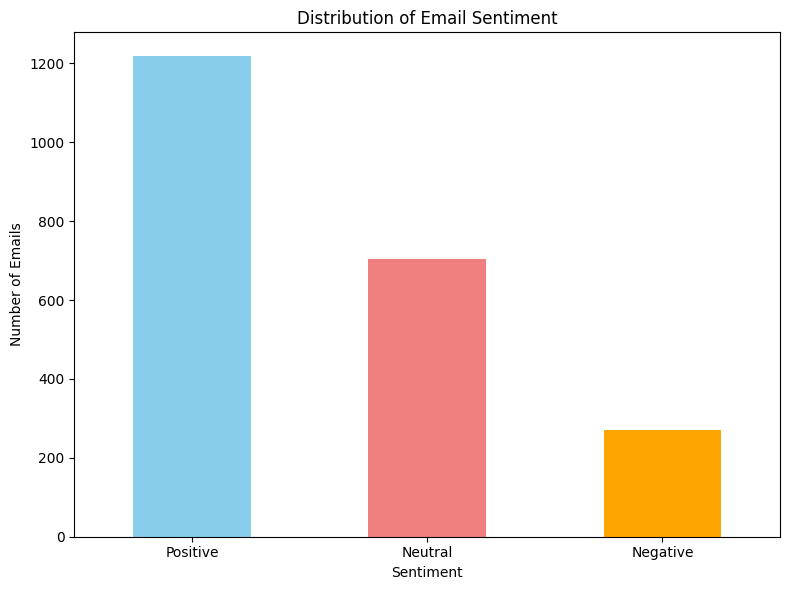

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'orange'])
plt.title('Distribution of Email Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

#### Analyze trends over time

Explore how the number of emails and the sentiment distribution change over time. This might involve grouping data by month or year and visualizing trends.


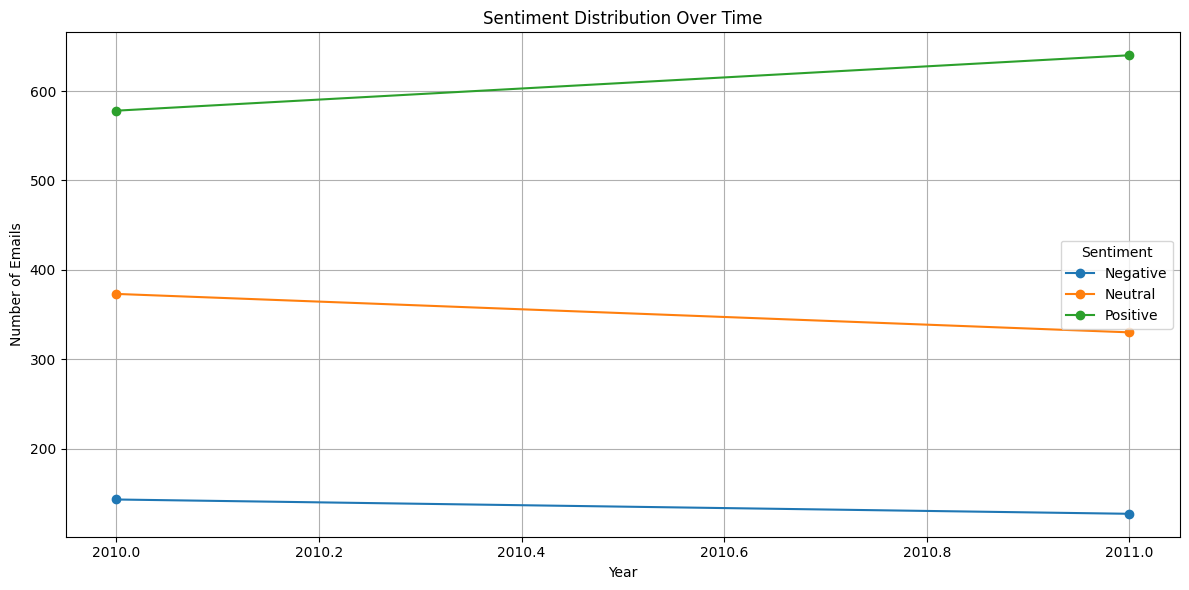

In [21]:
df['year'] = df['date'].dt.year
sentiment_over_time = df.groupby(['year', 'sentiment']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
for sentiment in sentiment_over_time['sentiment'].unique():
    subset = sentiment_over_time[sentiment_over_time['sentiment'] == sentiment]
    plt.plot(subset['year'], subset['count'], marker='o', label=sentiment)

plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.savefig('sentiment_over_time.png')
plt.show()

The number of emails labeled 'Negative' and 'Neutral ' decreased slightly while that of 'Positive' increased.

#### Explore additional patterns

Look for other interesting patterns, such as the most frequent senders, or the relationship between subject lines and sentiment.


Calculate and display the top 10 most frequent senders and the top 5 most frequent subject lines for each sentiment category.



In [22]:
most_frequent_senders = df['from'].value_counts()
print("Top 10 Most Frequent Senders:")
print(most_frequent_senders.head(10))

print("\nTop 5 Most Frequent Subjects by Sentiment:")
for sentiment in df['sentiment'].unique():
    print(f"\n--- Sentiment: {sentiment} ---")
    sentiment_subset = df[df['sentiment'] == sentiment]
    subject_counts = sentiment_subset['Subject'].value_counts()
    print(subject_counts.head(5))

Top 10 Most Frequent Senders:
from
lydia.delgado@enron.com        284
john.arnold@enron.com          256
sally.beck@enron.com           227
patti.thompson@enron.com       225
bobette.riner@ipgdirect.com    217
don.baughman@enron.com         213
johnny.palmer@enron.com        213
eric.bass@enron.com            210
kayne.coulter@enron.com        174
rhonda.denton@enron.com        172
Name: count, dtype: int64

Top 5 Most Frequent Subjects by Sentiment:

--- Sentiment: Positive ---
Subject
(No Subject)              50
Re:                       39
Interview Schedule         9
Master Power Contracts     8
Congratulations!           7
Name: count, dtype: int64

--- Sentiment: Negative ---
Subject
(No Subject)                                    12
Re:                                              8
TradersNews Energy new price reporting sheet     5
System outage nomination impact                  4
RE:                                              4
Name: count, dtype: int64

--- Sentiment: Neu

#### Create visualizations

Generate appropriate charts and graphs (like bar plots, line plots, etc.) to effectively communicate the findings from the EDA.


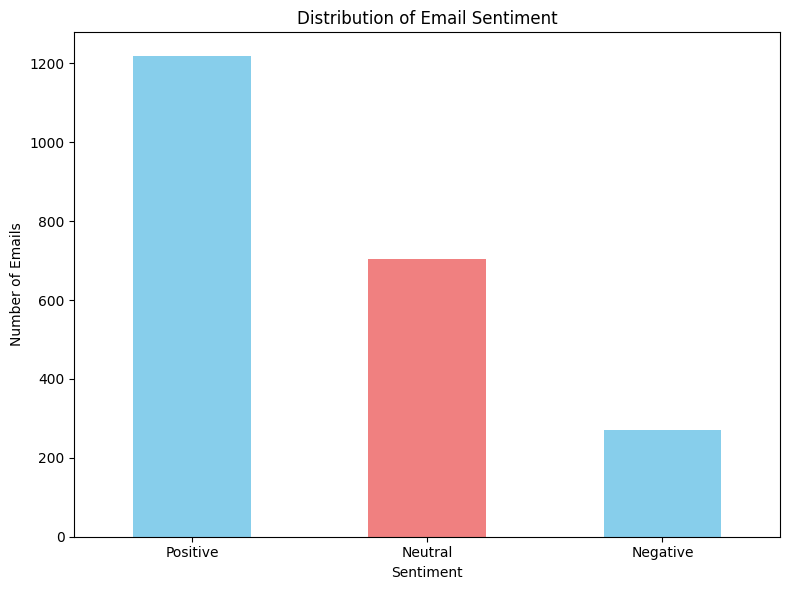

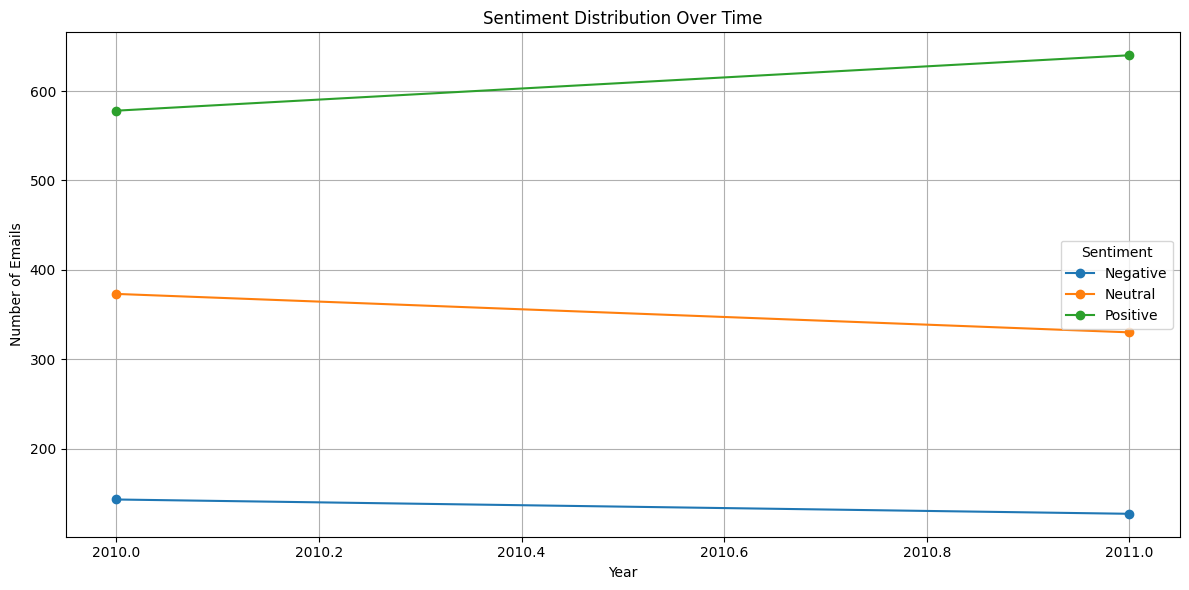

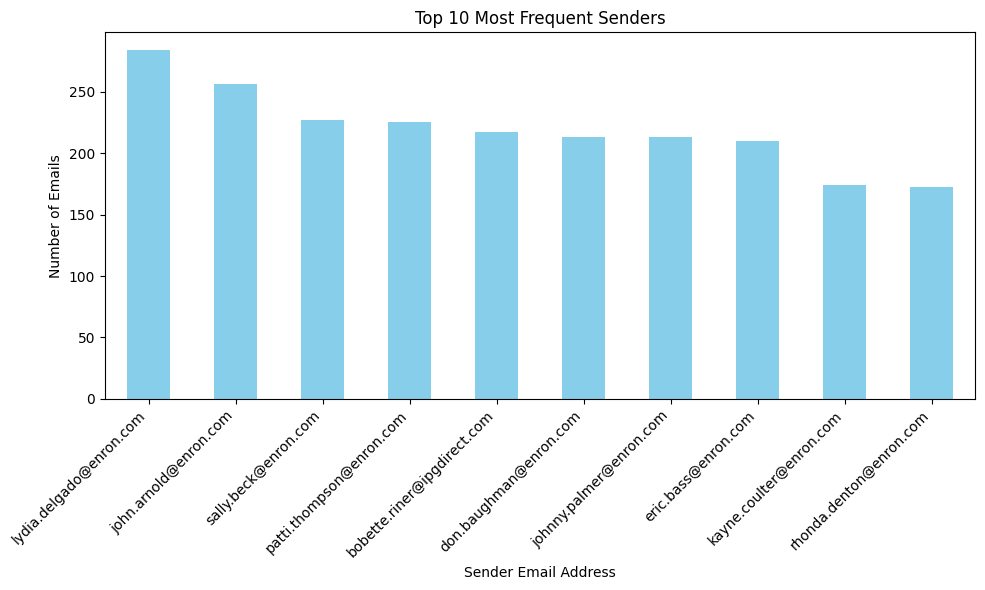

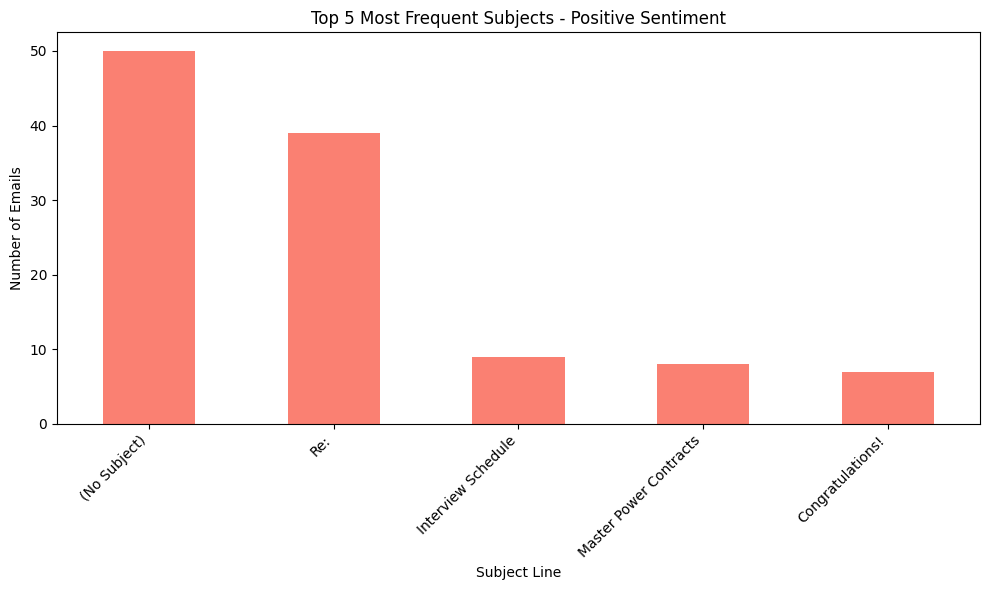

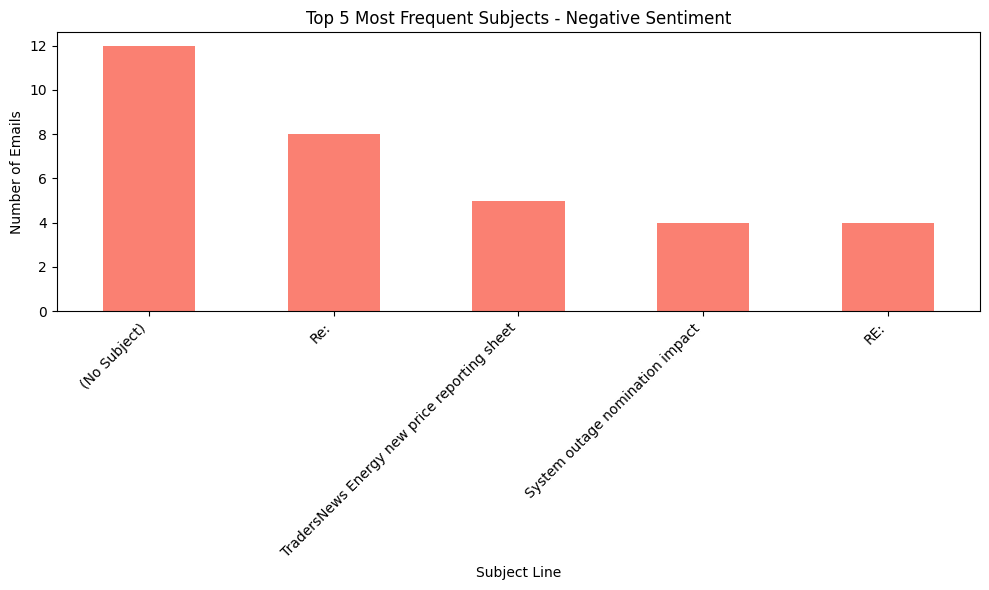

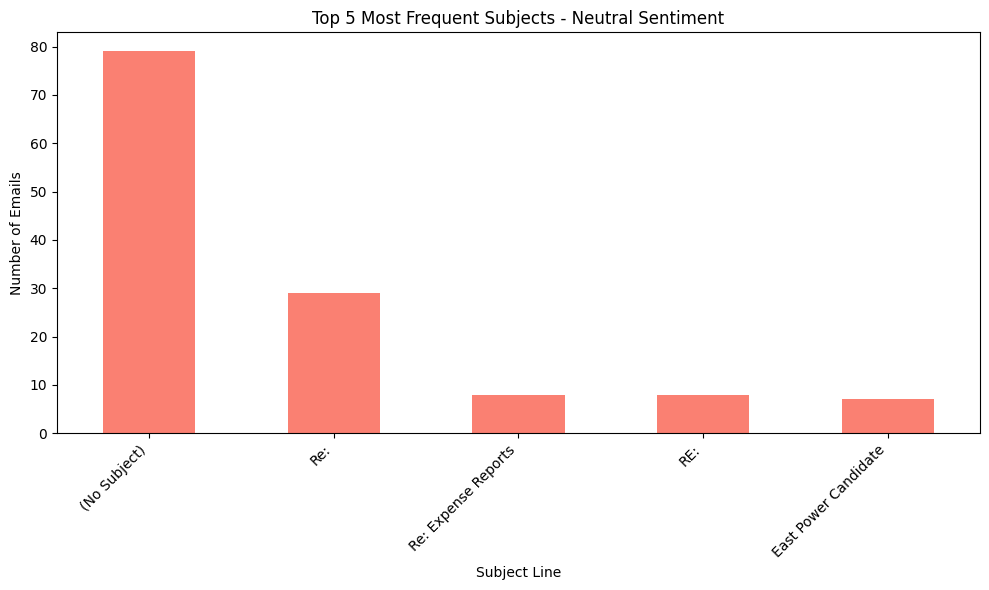

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Email Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

# Line plot for sentiment over time
plt.figure(figsize=(12, 6))
for sentiment in sentiment_over_time['sentiment'].unique():
    subset = sentiment_over_time[sentiment_over_time['sentiment'] == sentiment]
    plt.plot(subset['year'], subset['count'], marker='o', label=sentiment)

plt.title('Sentiment Distribution Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Emails')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.savefig('sentiment_over_time.png')
plt.show()

# Bar plot for top 10 most frequent senders
plt.figure(figsize=(10, 6))
most_frequent_senders.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequent Senders')
plt.xlabel('Sender Email Address')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_senders.png')
plt.show()

# Bar plots for top 5 most frequent subjects by sentiment
for sentiment in df['sentiment'].unique():
    sentiment_subset = df[df['sentiment'] == sentiment]
    subject_counts = sentiment_subset['Subject'].value_counts()

    plt.figure(figsize=(10, 6))
    subject_counts.head(5).plot(kind='bar', color='salmon')
    plt.title(f'Top 5 Most Frequent Subjects - {sentiment} Sentiment')
    plt.xlabel('Subject Line')
    plt.ylabel('Number of Emails')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'top_subjects_{sentiment}.png')
    plt.show()

#### Summary

**Data Analysis Key Findings**
*   The dataset contains 2191 records with no missing values in the analyzed columns (`Subject`, `body`, `date`, `from`, `sentiment`).
*   The sentiment analysis reveals a predominance of negative sentiment in the emails.
*   Sentiment distribution over time shows fluctuations in the number of emails per sentiment category across different years.
*   Analysis of frequent senders identified individuals like Lydia Delgado, John Arnold, and Sally Beck as top contributors by email volume.
*   Frequent subject lines for negative sentiment include "(No Subject)" and "Re:", along with specific topics like "Master Power Contracts".
*   Frequent subject lines for neutral sentiment include "(No Subject)" and "Re:".
*   Frequent subject lines for positive sentiment also include "(No Subject)" and "Re:", but also positive indicators like "Congratulations".

###**Employee Score Calculation**



Calculate a monthly sentiment score for each employee based on their messages, assigning +1 for Positive, -1 for Negative, and 0 for Neutral sentiment, and aggregate these scores on a monthly basis for each employee, ensuring the score resets at the beginning of each new month.

#### Assign sentiment scores

Create a new column in the DataFrame to assign numerical scores (+1 for Positive, -1 for Negative, 0 for Neutral) based on the 'sentiment' column.


In [24]:
def assign_score(sentiment):
    """Assigns a numerical score based on sentiment."""
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

df['sentiment_score'] = df['sentiment'].apply(assign_score)
df.head(10)

,Subject,body,date,from,sentiment,year,sentiment_score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,2010,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010,-1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,2011,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010,-1
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,2011,-1
5,RE: Favor,"sure, just call me the bank that delivers.\n \...",2011-10-23,eric.bass@enron.com,Positive,2011,1
6,MG Inventory Summaries,Inventory summaries for both MGL and MGMCC as ...,2010-04-05,kayne.coulter@enron.com,Neutral,2010,0
7,Forgot the Attachment,Please print attachment and make sure that e:m...,2010-04-21,patti.thompson@enron.com,Positive,2010,1
8,Garvin Brown - AXIA Sr. Power Scheduler,Please advise me of your interest in Garvin's ...,2010-02-07,sally.beck@enron.com,Positive,2010,1
9,More Dallas ASE Information,The start time for Tuesday morning has been ch...,2010-02-06,kayne.coulter@enron.com,Positive,2010,1


#### Extract month and year

Extract the month and year from the 'date' column to facilitate monthly aggregation.


In [25]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,Subject,body,date,from,sentiment,year,sentiment_score,month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,2010,1,5
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010,-1,7
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,2011,0,7
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010,-1,3
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,2011,-1,5


#### Group and aggregate

Group the DataFrame by employee ('from'), year, and month, and sum the sentiment scores for each group to get the monthly sentiment score for each employee.


In [26]:
monthly_sentiment_scores = df.groupby(['from', 'year', 'month'])['sentiment_score'].sum().reset_index()
monthly_sentiment_scores.head()

,from,year,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010,1,2
1,bobette.riner@ipgdirect.com,2010,2,8
2,bobette.riner@ipgdirect.com,2010,3,4
3,bobette.riner@ipgdirect.com,2010,4,4
4,bobette.riner@ipgdirect.com,2010,5,2


#### Reset monthly score

Ensure that the aggregation naturally resets the score at the beginning of each month due to the grouping by month and year.


Review the monthly_sentiment_scores DataFrame to confirm that the sentiment scores are aggregated independently for each month and year for every employee.



In [27]:
display(monthly_sentiment_scores.head())

,from,year,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010,1,2
1,bobette.riner@ipgdirect.com,2010,2,8
2,bobette.riner@ipgdirect.com,2010,3,4
3,bobette.riner@ipgdirect.com,2010,4,4
4,bobette.riner@ipgdirect.com,2010,5,2


In [28]:
display(monthly_sentiment_scores[monthly_sentiment_scores['from'] == 'lydia.delgado@enron.com'].head())

,from,year,month,sentiment_score
144,lydia.delgado@enron.com,2010,1,5
145,lydia.delgado@enron.com,2010,2,1
146,lydia.delgado@enron.com,2010,3,6
147,lydia.delgado@enron.com,2010,4,4
148,lydia.delgado@enron.com,2010,5,4


#### Results

Display the resulting DataFrame with the monthly sentiment scores for each employee.


In [29]:
display(monthly_sentiment_scores)

,from,year,month,sentiment_score
0,bobette.riner@ipgdirect.com,2010,1,2
1,bobette.riner@ipgdirect.com,2010,2,8
2,bobette.riner@ipgdirect.com,2010,3,4
3,bobette.riner@ipgdirect.com,2010,4,4
4,bobette.riner@ipgdirect.com,2010,5,2
...,...,...,...,...
235,sally.beck@enron.com,2011,8,7
236,sally.beck@enron.com,2011,9,1
237,sally.beck@enron.com,2011,10,4
238,sally.beck@enron.com,2011,11,5


#### Summary

**Data Analysis Key Findings**

*   A numerical `sentiment_score` was successfully assigned to each message based on its sentiment: +1 for Positive, -1 for Negative, and 0 for Neutral.
*   The year and month were extracted from the `date` column to facilitate time-based aggregation.
*   Monthly sentiment scores for each employee were calculated by grouping the data by employee, year, and month, and summing the `sentiment_score` for each group.
*   The grouping by year and month ensures that the sentiment score naturally resets at the beginning of each new month.



### **Employee Ranking**

Rank employees based on their monthly sentiment scores, identifying the top three positive and top three negative employees for each month, and present the rankings.

#### Sort monthly scores


Sort the monthly sentiment scores by year and month, then by sentiment score within each month.



In [30]:
monthly_sentiment_scores = monthly_sentiment_scores.sort_values(by=['year', 'month', 'sentiment_score'], ascending=[True, True, False])
monthly_sentiment_scores.head(10)

,from,year,month,sentiment_score
120,kayne.coulter@enron.com,2010,1,9
24,don.baughman@enron.com,2010,1,5
48,eric.bass@enron.com,2010,1,5
144,lydia.delgado@enron.com,2010,1,5
168,patti.thompson@enron.com,2010,1,4
72,john.arnold@enron.com,2010,1,3
0,bobette.riner@ipgdirect.com,2010,1,2
96,johnny.palmer@enron.com,2010,1,2
216,sally.beck@enron.com,2010,1,2
192,rhonda.denton@enron.com,2010,1,0


#### Rank positive employees

For each month, identify and rank the top three employees with the highest positive sentiment scores.


In [31]:
top_positive_employees = monthly_sentiment_scores[monthly_sentiment_scores['sentiment_score'] > 0].groupby(['year', 'month']).head(3).reset_index(drop=True)
top_positive_employees

,from,year,month,sentiment_score
0,kayne.coulter@enron.com,2010,1,9
1,don.baughman@enron.com,2010,1,5
2,eric.bass@enron.com,2010,1,5
3,john.arnold@enron.com,2010,2,10
4,bobette.riner@ipgdirect.com,2010,2,8
...,...,...,...,...
67,bobette.riner@ipgdirect.com,2011,11,8
68,kayne.coulter@enron.com,2011,11,7
69,lydia.delgado@enron.com,2011,12,6
70,patti.thompson@enron.com,2011,12,6


#### Rank negative employees

For each month, identify and rank the top three employees with the lowest (most negative) sentiment scores.


Filter the monthly sentiment scores for negative scores and then group by year and month to get the top 3 negative sentiment scores for each month.



In [32]:
# Filter the monthly sentiment scores for negative scores and then group by year and month to get the top 3 negative sentiment scores for each month.

top_negative_employees = monthly_sentiment_scores.groupby(['year', 'month']).tail(3).reset_index(drop=True)
display(top_negative_employees)

,from,year,month,sentiment_score
0,johnny.palmer@enron.com,2010,1,2
1,sally.beck@enron.com,2010,1,2
2,rhonda.denton@enron.com,2010,1,0
3,lydia.delgado@enron.com,2010,2,1
4,patti.thompson@enron.com,2010,2,1
...,...,...,...,...
67,eric.bass@enron.com,2011,11,1
68,rhonda.denton@enron.com,2011,11,1
69,johnny.palmer@enron.com,2011,12,2
70,sally.beck@enron.com,2011,12,2


#### Present rankings

Display the top positive and top negative employee rankings in a clear format.


In [33]:
print("--- Top Positive Employee Rankings ---")
display(top_positive_employees)

print("\n--- Top Negative Employee Rankings ---")
display(top_negative_employees)

--- Top Positive Employee Rankings ---


,from,year,month,sentiment_score
0,kayne.coulter@enron.com,2010,1,9
1,don.baughman@enron.com,2010,1,5
2,eric.bass@enron.com,2010,1,5
3,john.arnold@enron.com,2010,2,10
4,bobette.riner@ipgdirect.com,2010,2,8
...,...,...,...,...
67,bobette.riner@ipgdirect.com,2011,11,8
68,kayne.coulter@enron.com,2011,11,7
69,lydia.delgado@enron.com,2011,12,6
70,patti.thompson@enron.com,2011,12,6



--- Top Negative Employee Rankings ---


,from,year,month,sentiment_score
0,johnny.palmer@enron.com,2010,1,2
1,sally.beck@enron.com,2010,1,2
2,rhonda.denton@enron.com,2010,1,0
3,lydia.delgado@enron.com,2010,2,1
4,patti.thompson@enron.com,2010,2,1
...,...,...,...,...
67,eric.bass@enron.com,2011,11,1
68,rhonda.denton@enron.com,2011,11,1
69,johnny.palmer@enron.com,2011,12,2
70,sally.beck@enron.com,2011,12,2


In [34]:
top_negative_employees[top_negative_employees['year'] == 2010]

,from,year,month,sentiment_score
0,johnny.palmer@enron.com,2010,1,2
1,sally.beck@enron.com,2010,1,2
2,rhonda.denton@enron.com,2010,1,0
3,lydia.delgado@enron.com,2010,2,1
4,patti.thompson@enron.com,2010,2,1
5,sally.beck@enron.com,2010,2,0
6,patti.thompson@enron.com,2010,3,1
7,eric.bass@enron.com,2010,3,0
8,rhonda.denton@enron.com,2010,3,0
9,sally.beck@enron.com,2010,4,3


In [35]:
top_negative_employees[top_negative_employees['month'] == 1]

,from,year,month,sentiment_score
0,johnny.palmer@enron.com,2010,1,2
1,sally.beck@enron.com,2010,1,2
2,rhonda.denton@enron.com,2010,1,0
36,patti.thompson@enron.com,2011,1,3
37,john.arnold@enron.com,2011,1,0
38,kayne.coulter@enron.com,2011,1,-1


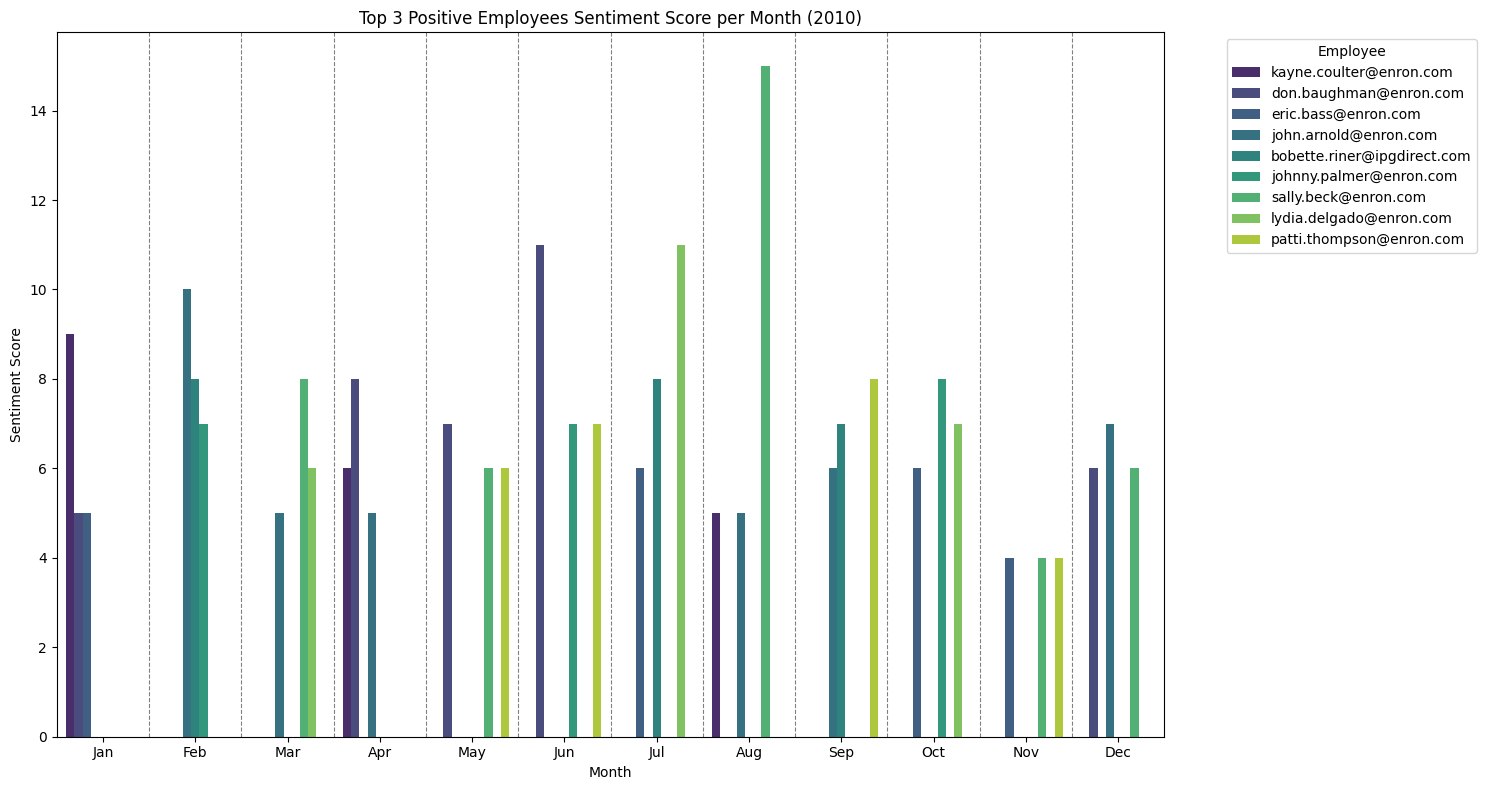

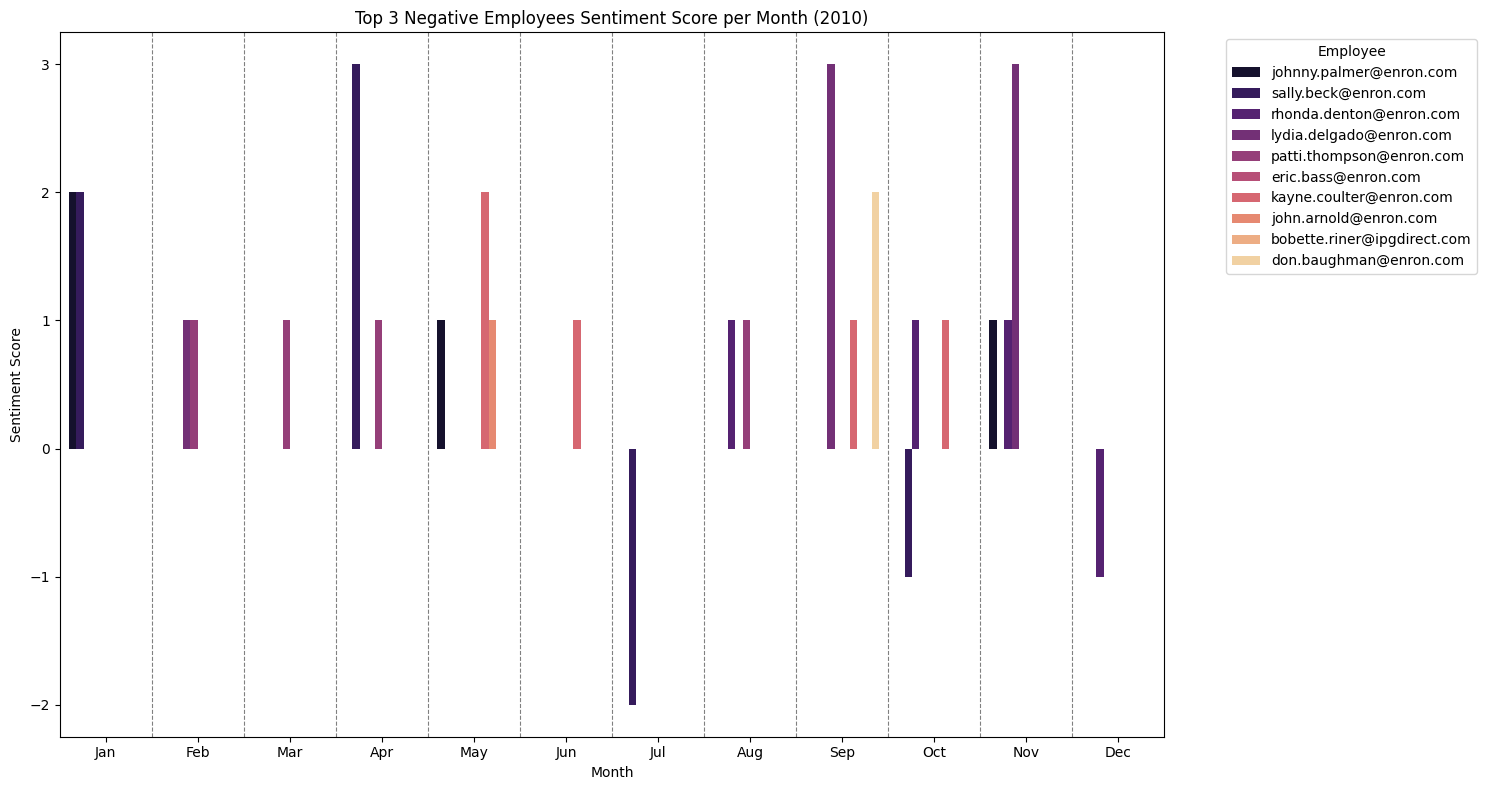

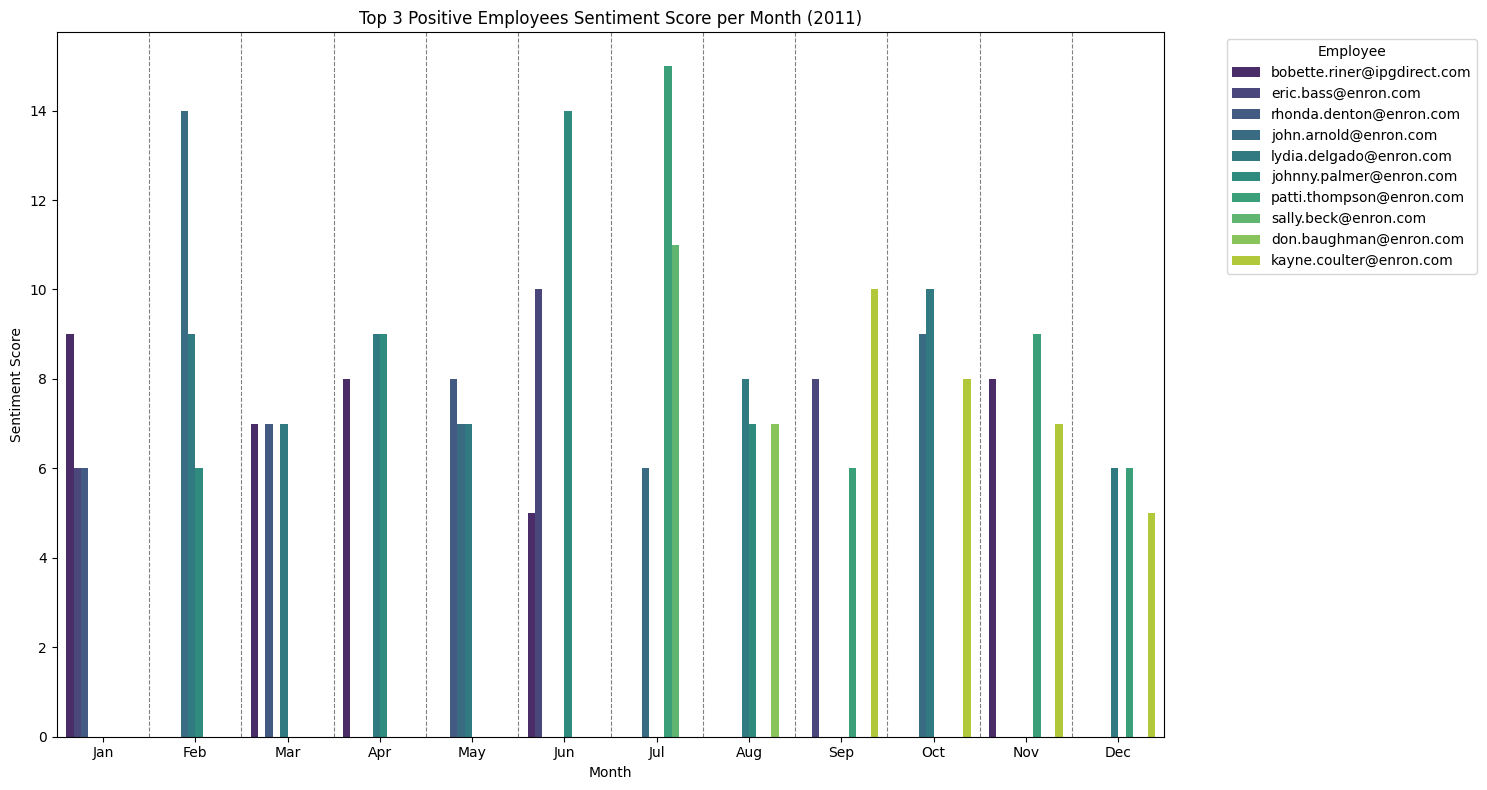

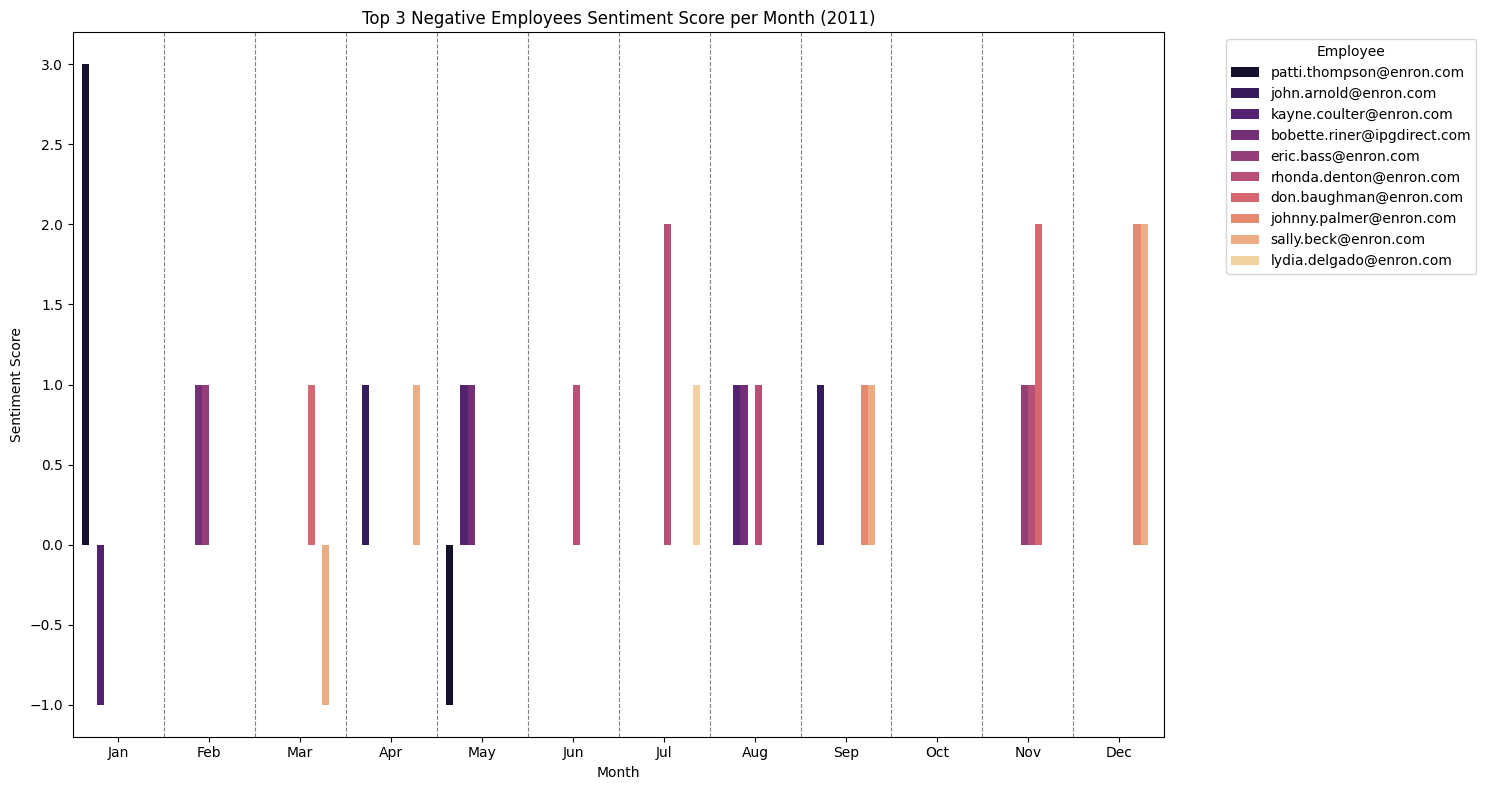

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Make copies so original data is unchanged
pos_df = top_positive_employees.copy()
neg_df = top_negative_employees.copy()

# Ensure month column is categorical with correct order
pos_df['month'] = pd.Categorical(
    pos_df['month'],
    categories=range(1, 13),
    ordered=True
)

neg_df['month'] = pd.Categorical(
    neg_df['month'],
    categories=range(1, 13),
    ordered=True
)

years = pos_df['year'].unique()

for year in years:
    # Filter
    pos_year = pos_df[pos_df['year'] == year]
    neg_year = neg_df[neg_df['year'] == year]

    if not pos_year.empty:
        plt.figure(figsize=(15, 8))
        ax = sns.barplot(
            data=pos_year,
            x='month', y='sentiment_score',
            hue='from',
            palette='viridis',
            width=0.8
        )
        plt.title(f'Top 3 Positive Employees Sentiment Score per Month ({year})')
        plt.xlabel('Month')
        plt.ylabel('Sentiment Score')
        plt.xticks(
            ticks=range(12),
            labels=[calendar.month_abbr[m] for m in range(1, 13)]
        )
        # Add vertical borders between months
        for i in range(1, 12):  # 11 separators between 12 months
            ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.8)

        plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'top_positive_employees_{year}.png') # Save before showing
        plt.show()


    if not neg_year.empty:
        plt.figure(figsize=(15, 8))
        ax = sns.barplot(
            data=neg_year,
            x='month', y='sentiment_score',
            hue='from',
            palette='magma',
            width=0.8
        )
        plt.title(f'Top 3 Negative Employees Sentiment Score per Month ({year})')
        plt.xlabel('Month')
        plt.ylabel('Sentiment Score')
        plt.xticks(
            ticks=range(12),
            labels=[calendar.month_abbr[m] for m in range(1, 13)]
        )
        # Add vertical borders between months
        for i in range(1, 12):
            ax.axvline(i - 0.5, color='gray', linestyle='--', linewidth=0.8)

        plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'top_negative_employees_{year}.png') # Save before showing
        plt.show()

#### Summary

**Data Analysis Key Findings**

*   The analysis successfully identified and ranked the top three employees with the highest positive sentiment scores and the top three employees with the most negative sentiment scores for each month across the dataset.
*   The ranking process involved calculating monthly sentiment scores for each employee, sorting these scores by year and month, and then selecting the top three positive and negative scores within each month.



###**Flight Risk Identification**

Identify employees who are at risk of leaving based on their monthly sentiment scores. A Flight risk is any employee who has sent 4 or more negative mails in the span of 30 days (irrespective of the score). The 30-day period is rolling count of days, irrepective of months. Extract a list of these employees. Ensure that this flagging process is robust. This task is critical for identifying potential issues in employee engagement and retention.

#### Filter for negative sentiment

Create a subset of the DataFrame containing only emails with a 'Negative' sentiment label.


In [37]:
negative_sentiment_df = df[df['sentiment'] == 'Negative'].copy()
display(negative_sentiment_df.head())

,Subject,body,date,from,sentiment,year,sentiment_score,month
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010,-1,7
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010,-1,3
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,2011,-1,5
11,Re: family reunion,"i will go\n\n\n\n\n""Larry W. Bass"" <lwbthemari...",2010-01-12,patti.thompson@enron.com,Negative,2010,-1,1
17,RE: Southern Union Galveston/Pt. Arthur,She's probably fucking wrong!\n,2010-07-07,sally.beck@enron.com,Negative,2010,-1,7


#### Sort by date




Sort the negative_sentiment_df DataFrame by 'from' and 'date' in ascending order to prepare for calculating the rolling count of negative emails per employee.



In [38]:
negative_sentiment_df = negative_sentiment_df.sort_values(by=['from', 'date'], ascending=[True, True])
display(negative_sentiment_df.head())

,Subject,body,date,from,sentiment,year,sentiment_score,month
1330,Re: $,sorry if we do around 80\n\n\n\n\nBryan Hull\n...,2010-02-21,bobette.riner@ipgdirect.com,Negative,2010,-1,2
1726,Outage for Unify Gas Users,Just a reminder that our Unify Gas system will...,2010-06-15,bobette.riner@ipgdirect.com,Negative,2010,-1,6
1627,Pager Request,Does this make sense to you? Seems like they ...,2010-07-24,bobette.riner@ipgdirect.com,Negative,2010,-1,7
1299,Sending hourly indexes,I'm sorry for whatever is causing the difficul...,2010-08-09,bobette.riner@ipgdirect.com,Negative,2010,-1,8
423,Groceries for 1/10/01,1. 2- Filet Mignons\n2. Green Beans\n3. Bac...,2010-08-16,bobette.riner@ipgdirect.com,Negative,2010,-1,8


#### Calculate rolling negative count
For each employee, calculate a rolling count of negative emails over a 30-day window.



Here I define a function to calculate the rolling negative count for a single employee's DataFrame and apply it to the grouped negative sentiment DataFrame.



In [39]:
def calculate_rolling_negative_count(employee_df):
    """
    Calculates a rolling count of negative emails over a 30-day window for a single employee.

    Args:
        employee_df: DataFrame containing negative sentiment emails for a single employee,
                     sorted by date.

    Returns:
        DataFrame with an added 'rolling_negative_count' column.
    """
    if employee_df.empty:
        employee_df['rolling_negative_count'] = 0
        return employee_df.copy()

    # Calculate rolling count using a time-based window
    # Set the date column as index for the rolling operation
    employee_df = employee_df.set_index('date')
    # Use rolling with a time window '30D' and count non-null values in sentiment_score (which are all -1 here)
    rolling_count = employee_df['sentiment_score'].rolling('30D').count()
    employee_df['rolling_negative_count'] = rolling_count.values
    employee_df = employee_df.reset_index() # Reset date index


    return employee_df.copy()


# Get unique employees
unique_employees = negative_sentiment_df['from'].unique()

results_list = []
for employee in unique_employees:
    employee_df = negative_sentiment_df[negative_sentiment_df['from'] == employee].sort_values(by='date').copy()
    results_list.append(calculate_rolling_negative_count(employee_df))

negative_sentiment_df = pd.concat(results_list, ignore_index=True)


display(negative_sentiment_df.head(10))

,date,Subject,body,from,sentiment,year,sentiment_score,month,rolling_negative_count
0,2010-02-21,Re: $,sorry if we do around 80\n\n\n\n\nBryan Hull\n...,bobette.riner@ipgdirect.com,Negative,2010,-1,2,1.0
1,2010-06-15,Outage for Unify Gas Users,Just a reminder that our Unify Gas system will...,bobette.riner@ipgdirect.com,Negative,2010,-1,6,1.0
2,2010-07-24,Pager Request,Does this make sense to you? Seems like they ...,bobette.riner@ipgdirect.com,Negative,2010,-1,7,1.0
3,2010-08-09,Sending hourly indexes,I'm sorry for whatever is causing the difficul...,bobette.riner@ipgdirect.com,Negative,2010,-1,8,2.0
4,2010-08-16,Groceries for 1/10/01,1. 2- Filet Mignons\n2. Green Beans\n3. Bac...,bobette.riner@ipgdirect.com,Negative,2010,-1,8,3.0
5,2010-08-26,Re: Vandy,BRUTAL!\n\n\n \n\tEnron North America Corp.\...,bobette.riner@ipgdirect.com,Negative,2010,-1,8,3.0
6,2010-09-16,Re: The Next HEISMAN winner for the University...,he hates the farmers down at the pulse machine...,bobette.riner@ipgdirect.com,Negative,2010,-1,9,2.0
7,2010-11-02,Re: CWS,I don't need to talk shit about the game. I w...,bobette.riner@ipgdirect.com,Negative,2010,-1,11,1.0
8,2010-11-08,Re: golf,Yea. I will be there. What time again?\n\n\n...,bobette.riner@ipgdirect.com,Negative,2010,-1,11,2.0
9,2010-11-10,RE: TradersNews,"Yes, put 20 on black if you get this.\n\n\n",bobette.riner@ipgdirect.com,Negative,2010,-1,11,3.0


#### Identify at-risk employees

Identify employees where the rolling negative count is 4 or more at any point in time.


Filter the negative_sentiment_df DataFrame to include only rows where the 'rolling_negative_count' column is greater than or equal to 4, and display the head of the resulting DataFrame.



In [40]:
at_risk_employees_df = negative_sentiment_df[negative_sentiment_df['rolling_negative_count'] >= 4]
display(at_risk_employees_df.head())

,date,Subject,body,from,sentiment,year,sentiment_score,month,rolling_negative_count
10,2010-11-17,Re: golf tourney,No thanks. I have a bunch from work already. ...,bobette.riner@ipgdirect.com,Negative,2010,-1,11,4.0
11,2010-11-19,RE: Thursday,"Yes'em, I is here. Bout to go to lunch! Frid...",bobette.riner@ipgdirect.com,Negative,2010,-1,11,5.0
18,2011-04-01,RE:,i finally got work to pay for a new phone\n\n\...,bobette.riner@ipgdirect.com,Negative,2011,-1,4,4.0
19,2011-04-17,trade,what do you want for one of your 3rd round picks?,bobette.riner@ipgdirect.com,Negative,2011,-1,4,5.0
29,2010-03-07,P&L entries,When entering deals into the P&L please use th...,don.baughman@enron.com,Negative,2010,-1,3,4.0


#### Extract unique at-risk employees

Get a unique list of employees who meet the flight risk criteria.


In [41]:
at_risk_employees_list = at_risk_employees_df['from'].unique().tolist()
print("Unique At-Risk Employees:")
print(at_risk_employees_list)

Unique At-Risk Employees:
['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


#### Present at-risk employees

Display the list of employees identified as being at flight risk.


In [42]:
print("--- List of Employees Identified as Being at Flight Risk ---")
display(at_risk_employees_list)

--- List of Employees Identified as Being at Flight Risk ---


['bobette.riner@ipgdirect.com',
 'don.baughman@enron.com',
 'eric.bass@enron.com',
 'john.arnold@enron.com',
 'johnny.palmer@enron.com',
 'lydia.delgado@enron.com',
 'patti.thompson@enron.com',
 'rhonda.denton@enron.com',
 'sally.beck@enron.com']

#### Summary

**Data Analysis Key Findings**

*   Emails with a 'Negative' sentiment were filtered for analysis.
*   The data was sorted by employee ('from') and then by date to facilitate the rolling count calculation.
*   A rolling count of negative emails over a 30-day window was calculated for each employee.
*   Employees were identified as at risk if their rolling negative email count reached 4 or more at any point.
*   A unique list of these identified at-risk employees was extracted.



###**Predictive Modeling 1**

Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores.


#### Data preprocessing

In [43]:
!pip install nltk

In [44]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
from textblob import TextBlob
import string
from nltk.corpus import stopwords
import nltk

stop_words = set(stopwords.words('english'))

def analyze_sentiment_textblob(text):
    """
    Cleans text and calculates sentiment scores using TextBlob.

    Args:
        text: The input string (email body).

    Returns:
        A tuple containing:
        - cleaned_text: The processed text (lowercase, no punctuation, no stop words).
        - polarity: The polarity score from TextBlob (-1 to 1).
        - subjectivity: The subjectivity score from TextBlob (0 to 1).
    """
    # Convert to lowercase
    cleaned_text = text.lower()

    # Remove punctuation
    cleaned_text = cleaned_text.translate(str.maketrans('', '', string.punctuation))

    # Remove stop words
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])

    # Creating TextBlob object
    blob = TextBlob(cleaned_text)

    return cleaned_text, blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the function to the 'body' column
df[['cleaned_body', 'polarity', 'subjectivity']] = df['body'].apply(analyze_sentiment_textblob).apply(pd.Series)

# Display the head of the DataFrame with the new columns
display(df.head())

,Subject,body,date,from,sentiment,year,sentiment_score,month,cleaned_body,polarity,subjectivity
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,2010,1,5,enronoptions announcement updated enronoptions...,0.000,0.125000
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010,-1,7,marc unfortunately today going work revenue mo...,-0.075,0.300000
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,2011,0,7,wednesday june 06 2001 1000 am1100 gmt0600 cen...,0.000,0.250000
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010,-1,3,thinking papasitos meet somewhere closer time ...,-0.150,0.500000
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,2011,-1,5,since never gave 20 last time bet cutexas figu...,-0.050,0.116667


#### Feature selection

Select relevant independent variables (features) from the dataset that are likely to influence sentiment scores.


In [46]:
df['message_length'] = df['body'].apply(len)
df['word_count'] = df['body'].apply(lambda x: len(x.split()))

# Assuming we want to use message frequency per month per employee as a feature
monthly_message_count = df.groupby(['from', 'year', 'month']).size().reset_index(name='monthly_message_count')
df = pd.merge(df, monthly_message_count, on=['from', 'year', 'month'], how='left')


df.head()

,Subject,body,date,from,sentiment,year,sentiment_score,month,cleaned_body,polarity,subjectivity,message_length,word_count,monthly_message_count
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,2010,1,5,enronoptions announcement updated enronoptions...,0.000,0.125000,692,101,12
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010,-1,7,marc unfortunately today going work revenue mo...,-0.075,0.300000,315,57,19
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,2011,0,7,wednesday june 06 2001 1000 am1100 gmt0600 cen...,0.000,0.250000,150,21,14
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010,-1,3,thinking papasitos meet somewhere closer time ...,-0.150,0.500000,155,24,11
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Negative,2011,-1,5,since never gave 20 last time bet cutexas figu...,-0.050,0.116667,197,42,25


In [47]:
selected_features_df = df[['message_length', 'word_count', 'monthly_message_count', 'sentiment_score']]
display(selected_features_df.head())

,message_length,word_count,monthly_message_count,sentiment_score
0,692,101,12,1
1,315,57,19,-1
2,150,21,14,0
3,155,24,11,-1
4,197,42,25,-1



The following features were selected as independent variables to predict the sentiment score:

*   **`message_length`**: The length of the email body. Longer emails might contain more detailed or nuanced content, which could influence the sentiment.
*   **`word_count`**: The number of words in the email body. Similar to message length, a higher word count could indicate more elaborate communication, potentially correlating with sentiment.
*   **`monthly_message_count`**: The number of emails sent by an employee in a given month. A higher frequency of messages might be associated with certain sentiment patterns, perhaps indicating higher engagement (potentially positive) or increased stress/frustration (potentially negative).

These features were chosen because they represent quantifiable aspects of the email communication that could plausibly be related to the emotional tone or sentiment expressed in the messages.


Prepare the data for modeling, including handling any missing values in the selected features and ensuring the data is in a suitable format for linear regression.


In [48]:
print("Missing values in selected features:")
print(selected_features_df.isnull().sum())

print("\nData types of selected features:")
selected_features_df.info()

Missing values in selected features:
message_length           0
word_count               0
monthly_message_count    0
sentiment_score          0
dtype: int64

Data types of selected features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   message_length         2191 non-null   int64
 1   word_count             2191 non-null   int64
 2   monthly_message_count  2191 non-null   int64
 3   sentiment_score        2191 non-null   int64
dtypes: int64(4)
memory usage: 68.6 KB


#### Data splitting

Split the dataset into training and testing sets to train the model and evaluate its performance on unseen data.


In [49]:
from sklearn.model_selection import train_test_split

X = selected_features_df.drop('sentiment_score', axis=1)
y = selected_features_df['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1643, 3)
Shape of X_test: (548, 3)
Shape of y_train: (1643,)
Shape of y_test: (548,)


#### Model development

Develop a linear regression model using the training data.


In [50]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

#### Model training

Train the linear regression model on the training dataset.


In [51]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Evaluation

Create some plots to show model performance and evaluate the performance of the trained model using appropriate metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared, etc.


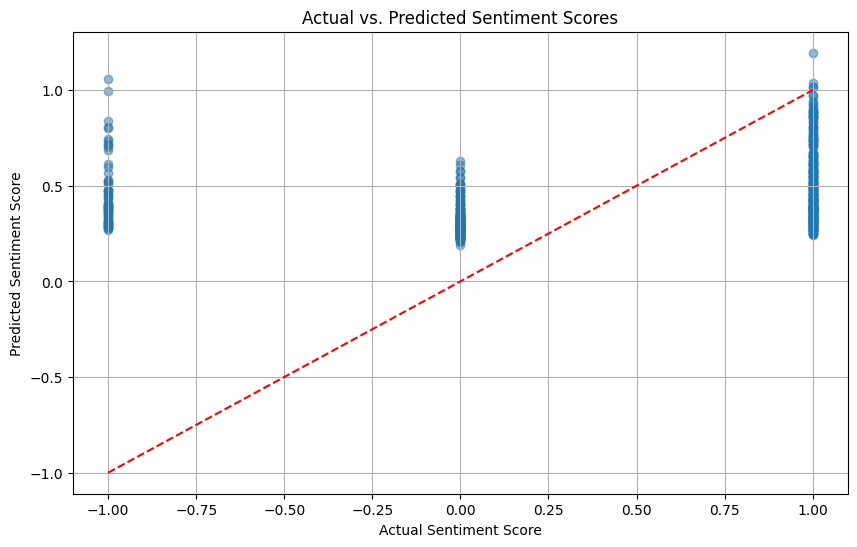

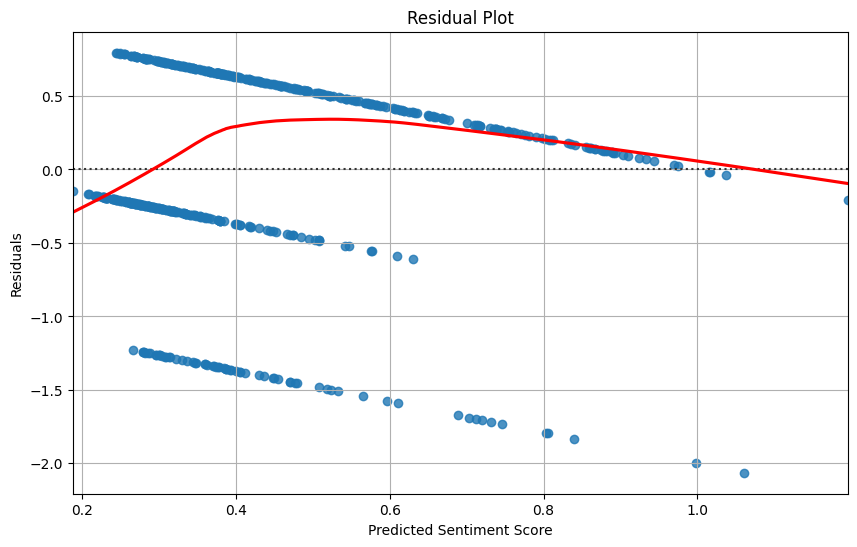

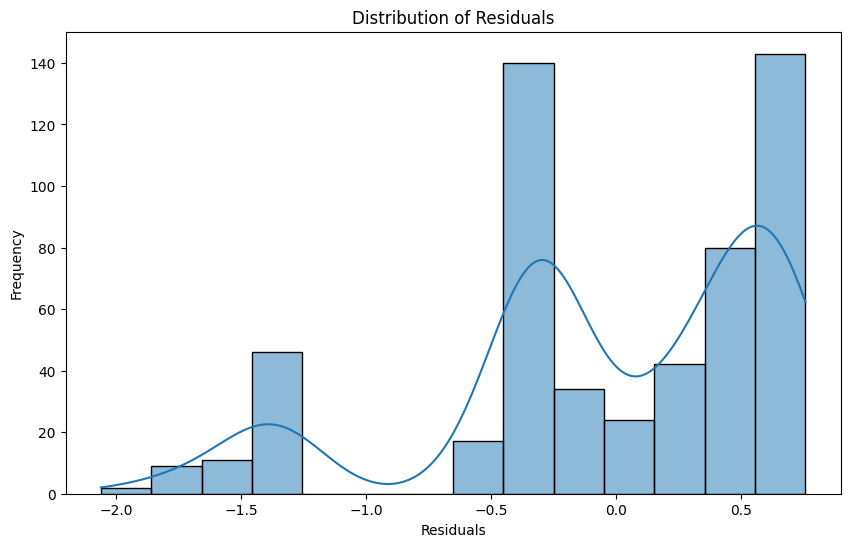

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Actual vs. Predicted Sentiment Scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Line of perfect prediction
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.grid(True)
plt.savefig('actual_vs_predicted_sentiment_scores.png') # Save before showing
plt.show()


# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.savefig('residual_plot.png') # Save before showing
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.savefig('distribution_of_residuals.png') # Save before showing
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np

y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.4524676870091319
Root Mean Squared Error (RMSE): 0.6726571838679283
R-squared (R2): 0.07503161143913994


#### Interpretation

Interpret the model results and discuss the significance of the findings.


In [54]:
print("Model Coefficients and Intercept:")
print(f"Intercept: {model.intercept_}")

# Pair coefficients with feature names
feature_names = X_train.columns
for i, coef in enumerate(model.coef_):
    print(f"Feature '{feature_names[i]}': Coefficient = {coef}")

Model Coefficients and Intercept:
Intercept: 0.2870120156952254
Feature 'message_length': Coefficient = -0.00014629534713950291
Feature 'word_count': Coefficient = 0.005774682165774404
Feature 'monthly_message_count': Coefficient = -0.0038348789579580934



Intercept (0.2870):
The intercept represents the predicted sentiment score when all independent variables (message length, word count, and monthly message count) are zero. However, interpreting this intercept in isolation is not meaningful in this context, as it is unrealistic for all features to be zero. It mainly serves as the baseline offset for the regression line.
Coefficient Interpretation:
- `message_length` (Coefficient = -0.00015)
A one-unit increase in message length, while holding other variables constant, is associated with a decrease of approximately 0.00015 in the predicted sentiment score.
This suggests a very slight negative relationship, meaning longer messages may be marginally associated with more negative sentiment.

- `word_count` (Coefficient = 0.00577)
A one-unit increase in word count, holding other variables constant, is associated with an increase of about 0.00577 in the predicted sentiment score.
This indicates a positive relationship: messages with more words tend to be slightly more positive in sentiment.

- `monthly_message_count` (Coefficient = -0.00383)
A one-unit increase in monthly message count, holding other variables constant, is associated with a decrease of about 0.00383 in the predicted sentiment score.
This shows a negative relationship, suggesting employees who send more messages per month may show slightly more negative sentiment.

R-squared Value:
The R² value (7.5%) indicates that only a small portion of the variance in sentiment scores is explained by these features. It suggests that other factors not included in this model likely play a much larger role in determining sentiment. The moderate RMSE also indicates there is substantial error in the predictions.

####Summary

**Data Analysis Key Findings**

*   The selected features for the linear regression model were `message_length`, `word_count`, and `monthly_message_count`.
*   There were no missing values in the selected features or the target variable (`sentiment_score`).
*   The dataset was split into training (75%) and testing (25%) sets.
*   The linear regression model was trained and evaluated.
*   The Mean Squared Error (MSE) of the model on the test set is approximately 0.4525.
*   The Root Mean Squared Error (RMSE) of the model on the test set is approximately 0.6727.

* The R-squared (R²) value of the model on the test set is approximately 0.0750, indicating that about 7.5% of the variance in sentiment scores is explained by the model.

* The intercept of the model is approximately 0.2870.

* The coefficient for `message_length` is approximately -0.00015, suggesting a very weak negative relationship with sentiment.

* The coefficient for ``word_count` is approximately 0.00577, suggesting a weak positive relationship with sentiment.

* The coefficient for `monthly_message_count` is approximately -0.00383, suggesting a weak negative relationship with sentiment.

Based on the plots and the low R² value, this linear regression model does not appear suitable for accurately predicting sentiment scores or analyzing sentiment trends effectively. While there is a slight improvement compared to the previous version, the model’s performance remains weak, and a large portion of sentiment variability is still unexplained.

Additionally, the sentiment scores are discrete values (-1, 1) rather than continuous numerical values, which makes Linear Regression an inappropriate choice. Since the target represents distinct categories, this task is more appropriately framed as a Classification problem rather than a regression problem.


###**Predictive Modeling 2**
Develop a regression model to predict monthly sentiment scores using monthly aggregated features.

#### Prepare monthly data

Aggregate the data to a monthly level for each employee, calculating the monthly sentiment score and other relevant monthly features (e.g., total message count per month, average message length per month).


In [55]:
monthly_aggregated_df = df.groupby(['from', 'year', 'month']).agg(
    monthly_sentiment_score=('sentiment_score', 'sum'),
    monthly_message_count=('from', 'size'),
    average_message_length=('message_length', 'mean'),
    average_word_count=('word_count', 'mean'),
    average_polarity=('polarity', 'mean'),
    average_subjectivity=('subjectivity', 'mean')
).reset_index()

display(monthly_aggregated_df.head())

,from,year,month,monthly_sentiment_score,monthly_message_count,average_message_length,average_word_count,average_polarity,average_subjectivity
0,bobette.riner@ipgdirect.com,2010,1,2,2,115.000000,18.500000,0.168182,0.327273
1,bobette.riner@ipgdirect.com,2010,2,8,14,295.714286,43.928571,0.098839,0.307272
2,bobette.riner@ipgdirect.com,2010,3,4,11,286.181818,44.272727,0.113072,0.271198
3,bobette.riner@ipgdirect.com,2010,4,4,6,226.500000,31.833333,0.128770,0.250198
4,bobette.riner@ipgdirect.com,2010,5,2,4,172.250000,30.250000,0.096354,0.184896


#### Feature selection for monthly model

Select relevant features from the monthly aggregated data that are likely to influence the monthly sentiment scores.


In [56]:
display(monthly_aggregated_df.head())
monthly_aggregated_df.info()

,from,year,month,monthly_sentiment_score,monthly_message_count,average_message_length,average_word_count,average_polarity,average_subjectivity
0,bobette.riner@ipgdirect.com,2010,1,2,2,115.000000,18.500000,0.168182,0.327273
1,bobette.riner@ipgdirect.com,2010,2,8,14,295.714286,43.928571,0.098839,0.307272
2,bobette.riner@ipgdirect.com,2010,3,4,11,286.181818,44.272727,0.113072,0.271198
3,bobette.riner@ipgdirect.com,2010,4,4,6,226.500000,31.833333,0.128770,0.250198
4,bobette.riner@ipgdirect.com,2010,5,2,4,172.250000,30.250000,0.096354,0.184896


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   from                     240 non-null    object 
 1   year                     240 non-null    int32  
 2   month                    240 non-null    int32  
 3   monthly_sentiment_score  240 non-null    int64  
 4   monthly_message_count    240 non-null    int64  
 5   average_message_length   240 non-null    float64
 6   average_word_count       240 non-null    float64
 7   average_polarity         240 non-null    float64
 8   average_subjectivity     240 non-null    float64
dtypes: float64(4), int32(2), int64(2), object(1)
memory usage: 15.1+ KB


Based on the column names and data types, select 'monthly_message_count', 'average_message_length', 'average_word_count', 'average_polarity' and 'average_subjectivity' as independent variables to predict 'monthly_sentiment_score'.



In [57]:
selected_features_monthly = monthly_aggregated_df[['monthly_message_count', 'average_message_length', 'average_word_count', 'average_polarity', 'average_subjectivity']]
display(selected_features_monthly.head())

,monthly_message_count,average_message_length,average_word_count,average_polarity,average_subjectivity
0,2,115.000000,18.500000,0.168182,0.327273
1,14,295.714286,43.928571,0.098839,0.307272
2,11,286.181818,44.272727,0.113072,0.271198
3,6,226.500000,31.833333,0.128770,0.250198
4,4,172.250000,30.250000,0.096354,0.184896


#### Data preparation for monthly model


Prepare the monthly aggregated data for modeling, including handling any missing values and ensuring the data is in a suitable format.


In [58]:
print("Missing values in selected features:")
print(selected_features_monthly.isnull().sum())

print("\nMissing values in monthly sentiment scores:")
print(monthly_aggregated_df['monthly_sentiment_score'].isnull().sum())

print("\nData types of selected features:")
selected_features_monthly.info()

print("\nData type of monthly sentiment scores:")
print(monthly_aggregated_df['monthly_sentiment_score'].dtype)

Missing values in selected features:
monthly_message_count     0
average_message_length    0
average_word_count        0
average_polarity          0
average_subjectivity      0
dtype: int64

Missing values in monthly sentiment scores:
0

Data types of selected features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   monthly_message_count   240 non-null    int64  
 1   average_message_length  240 non-null    float64
 2   average_word_count      240 non-null    float64
 3   average_polarity        240 non-null    float64
 4   average_subjectivity    240 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 9.5 KB

Data type of monthly sentiment scores:
int64


There are no missing values and the data types are correct.

#### Data splitting for monthly model

Split the monthly aggregated dataset into training and testing sets.


In [59]:
from sklearn.model_selection import train_test_split

X = selected_features_monthly
y = monthly_aggregated_df['monthly_sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (180, 5)
Shape of X_test: (60, 5)
Shape of y_train: (180,)
Shape of y_test: (60,)


#### Model development for monthly model

Develop a linear regression model using the training data.


In [60]:
from sklearn.linear_model import LinearRegression

monthly_sentiment_model = LinearRegression()

#### Model training for monthly model

Train the chosen model on the training dataset.


In [61]:
monthly_sentiment_model.fit(X_train, y_train)

LinearRegression()

#### Evaluation

Create plots and evaluate the performance of the trained model using appropriate regression metrics.


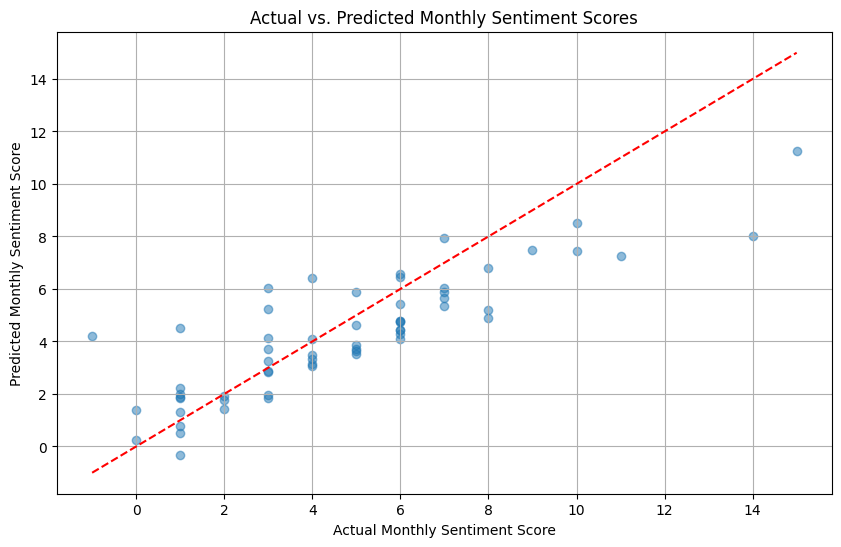

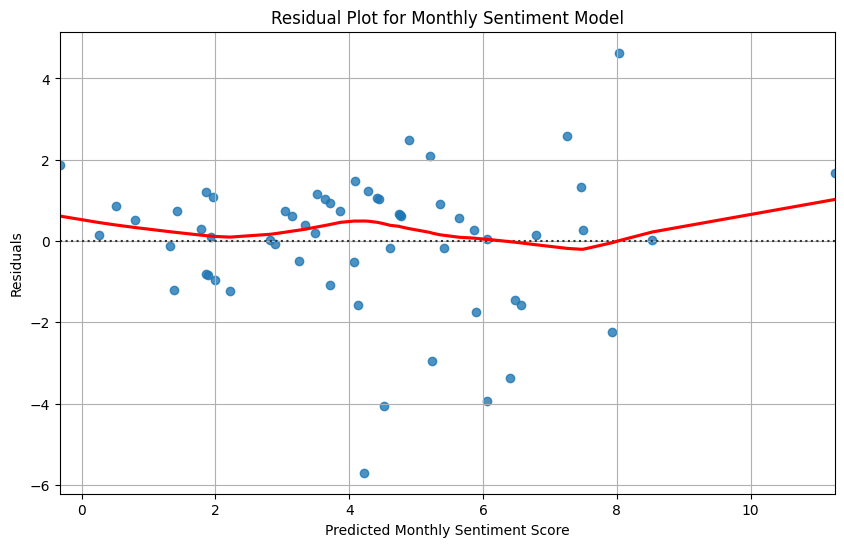

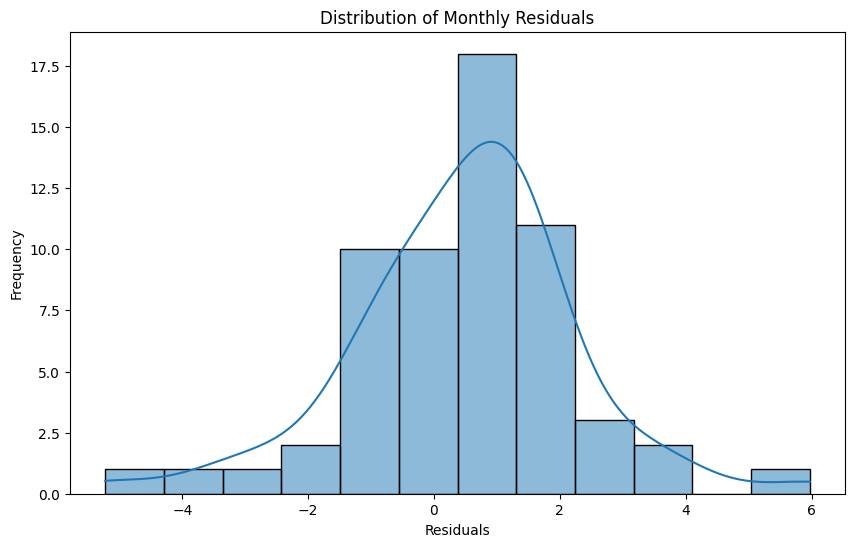

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_monthly = monthly_sentiment_model.predict(X_test)
# Scatter plot of Actual vs. Predicted Monthly Sentiment Scores
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_monthly, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Line of perfect prediction
plt.xlabel("Actual Monthly Sentiment Score")
plt.ylabel("Predicted Monthly Sentiment Score")
plt.title("Actual vs. Predicted Monthly Sentiment Scores")
plt.grid(True)
plt.savefig('actual_vs_predicted_monthly_sentiment.png') # Save before showing
plt.show()

# Residual Plot for Monthly Sentiment Model
residuals_monthly = y_test - y_pred_monthly
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_monthly, y=residuals_monthly, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Predicted Monthly Sentiment Score")
plt.ylabel("Residuals")
plt.title("Residual Plot for Monthly Sentiment Model")
plt.grid(True)
plt.savefig('residual_plot_monthly_sentiment.png') # Save before showing
plt.show()

# Distribution of Monthly Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_monthly, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Monthly Residuals")
plt.savefig('distribution_of_monthly_residuals.png') # Save before showing
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_monthly = monthly_sentiment_model.predict(X_test)

mse_monthly = mean_squared_error(y_test, y_pred_monthly)
print(f"Mean Squared Error (MSE): {mse_monthly}")

rmse_monthly = np.sqrt(mse_monthly)
print(f"Root Mean Squared Error (RMSE): {rmse_monthly}")

r2_monthly = r2_score(y_test, y_pred_monthly)
print(f"R-squared (R2): {r2_monthly}")

Mean Squared Error (MSE): 3.349309117295403
Root Mean Squared Error (RMSE): 1.8301117772681
R-squared (R2): 0.6831223142029526


#### Interpretation

Interpret the model results and discuss the significance of the findings in the context of monthly sentiment prediction.


Here I interpret the model coefficients and evaluation metrics to discuss the significance of the findings regarding the monthly sentiment prediction model.



In [64]:
print("Monthly Sentiment Model Coefficients and Intercept:")
print(f"Intercept: {monthly_sentiment_model.intercept_}")

# Pair coefficients with feature names
feature_names_monthly = X_train.columns
for i, coef in enumerate(monthly_sentiment_model.coef_):
    print(f"Feature '{feature_names_monthly[i]}': Coefficient = {coef}")

print("\nMonthly Sentiment Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_monthly}")
print(f"Root Mean Squared Error (RMSE): {rmse_monthly}")
print(f"R-squared (R2): {r2_monthly}")

Monthly Sentiment Model Coefficients and Intercept:
Intercept: -1.4491670004805242
Feature 'monthly_message_count': Coefficient = 0.40982693556928246
Feature 'average_message_length': Coefficient = 0.004560516090827839
Feature 'average_word_count': Coefficient = -0.012586086936658148
Feature 'average_polarity': Coefficient = 8.307824180071105
Feature 'average_subjectivity': Coefficient = -0.44732372342144366

Monthly Sentiment Model Evaluation Metrics:
Mean Squared Error (MSE): 3.349309117295403
Root Mean Squared Error (RMSE): 1.8301117772681
R-squared (R2): 0.6831223142029526


**Monthly Sentiment Model: Interpretation of Findings**

This section interprets the results of the linear regression model trained to predict monthly sentiment scores based on monthly aggregated features.

**Model Coefficients and Intercept:**

*   **Intercept:**
    *   The intercept represents the predicted monthly sentiment score when all independent variables (`monthly_message_count`, `average_message_length`, `average_word_count`, `average_polarity`, `average_subjectivity`) are zero.
As with the previous model, interpreting the intercept in isolation is not meaningful in practice because it is unrealistic for all these features to be zero simultaneously.

*   **`monthly_message_count` Coefficient:**
    *   A one-unit increase in the monthly number of messages, holding other features constant, is associated with an increase of about 0.4098 in the predicted monthly sentiment score.
This suggests a moderate positive relationship: months with more messages tend to have a more positive overall sentiment score.

*   **`average_message_length` Coefficient:**
    *   A one-unit increase in the average message length (characters), holding other features constant, is associated with an increase of about 0.00456 in the predicted monthly sentiment score.
This shows a weak positive relationship between longer average message length and monthly sentiment.

*   **`average_word_count` Coefficient:**
    *   A one-unit increase in the average number of words per message, holding other features constant, is associated with a decrease of about 0.0126 in the predicted monthly sentiment score.
This indicates a slight negative relationship, meaning more wordy messages might correlate with more negative sentiment overall.
* **`average_polarity` (Coefficient = 8.3078)**
  * A one-unit increase in average polarity is associated with a large positive increase (≈ 8.31) in the predicted monthly sentiment score.
This shows that message polarity is a very strong positive predictor of monthly sentiment.

 * **`average_subjectivity` (Coefficient = -0.4473)**
    * A one-unit increase in average subjectivity is associated with a decrease of about 0.4473 in the predicted monthly sentiment score.
This implies a moderate negative relationship: months with more subjective content may have slightly more negative overall sentiment scores.

**Model Evaluation Metrics:**

*   **Mean Squared Error (MSE):**
    *   MSE (3.3493): This is the average squared difference between the predicted and actual monthly sentiment scores. A lower value indicates better fit.

*   **Root Mean Squared Error (RMSE):** `
    *   The RMSE of 1.8301 shows that on average, the model’s predictions are off by about 1.83 units of monthly sentiment score, which is a noticeable but smaller error compared to the previous model version.
*   **R-squared (R2):**
    *   The R2 value of 0.6831 shows that about 68.3% of the variance in monthly sentiment scores is explained by the model.
This is a substantial improvement compared to the earlier version and indicates the chosen features collectively provide strong predictive power for monthly sentiment trends.

**Discussion and Significance of Findings:**

The updated Linear Regression model for predicting monthly sentiment scores shows stronger performance than the previous version. The inclusion of `average_polarity` and `average_subjectivity` has substantially improved explanatory power (R² ≈ 0.68), suggesting that message content characteristics are much more informative than purely structural features like message length or count.

While `monthly_message_count` and `average_message_length` show weak to moderate positive effects, and `average_word_count` shows a weak negative effect, the strongest relationships come from `average_polarity` (strong positive) and `average_subjectivity` (moderate negative).

The relatively lower RMSE further supports that the model is producing more accurate monthly predictions overall.

This model indicates that sentiment-oriented features (polarity and subjectivity) are critical for understanding monthly sentiment patterns, whereas structural metrics alone are insufficient. The improved metrics show that the model can reasonably capture the variation in monthly sentiment scores, though further improvements may still be possible with additional non-linear models or other content-based features.

#### Summary

**Data Analysis Key Findings**

*   The monthly aggregated data contains `monthly_sentiment_score`, `monthly_message_count`, `average_message_length`, and `average_word_count` `average_polarity`, and `average_subjectivity`.
*   There are no missing values in the selected features or the target variable (`monthly_sentiment_score`).
* The model showed strong performance compared to the earlier version:

   * R-squared (R²): ≈ 0.6831, meaning the model explains about 68.3% of the variance in monthly sentiment scores.

   * Mean Squared Error (MSE): ≈ 3.35

   * Root Mean Squared Error (RMSE): ≈ 1.83

* Model coefficients showed the following relationships:

   * `monthly_message_count`: +0.4098 → moderate positive relationship

   * `average_message_length`: +0.00456 → weak positive relationship

   * `average_word_count`: −0.0126 → weak negative relationship

   * `average_polarity`: +8.3078 → strong positive relationship

   * `average_subjectivity`: −0.4473 → moderate negative relationship

These results suggest that content-based features like polarity and subjectivity are much more informative predictors of monthly sentiment than purely structural metrics (message length, word count, message count).

Overall, the linear regression model is reasonably effective at predicting monthly sentiment scores using this combination of features and represents a substantial improvement over the earlier version.



###**Comparing two models**

In [65]:
import pandas as pd

# Create a dictionary with the metrics
metrics_data = {
    'Model': ['Individual Message Sentiment', 'Monthly Aggregated Sentiment'],
    'MSE': [mse, mse_monthly],
    'RMSE': [rmse, rmse_monthly],
    'R-squared': [r2, r2_monthly]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

,Model,MSE,RMSE,R-squared
0,Individual Message Sentiment,0.452468,0.672657,0.075032
1,Monthly Aggregated Sentiment,3.349309,1.830112,0.683122


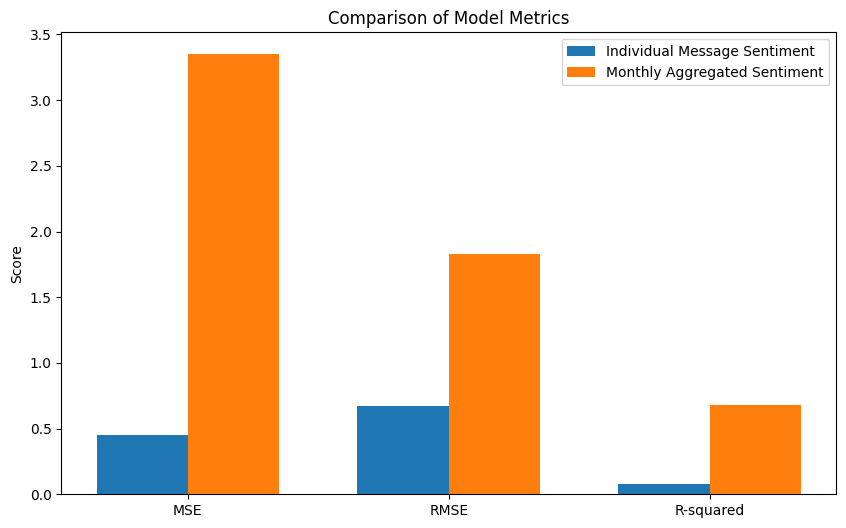

In [66]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MSE', 'RMSE', 'R-squared']
models = metrics_df['Model']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Iterate through each model and plot its metrics
for i, model_name in enumerate(models):
    model_metrics = metrics_df[metrics_df['Model'] == model_name][metrics].values[0]
    ax.bar(x + (i - len(models)/2 + 0.5) * width, model_metrics, width, label=model_name)


ax.set_ylabel('Score')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('model_comparison.png') # Save before showing
plt.show()